# Computation of variances using ECMWF forecasts and NMC method

In this Notebook we will:
- Load the datasets (surface and profile variables)
- Manipulate dimensions and prepare to build a single dataset that contains the differences between two different forecasts
- Convert units to more favorable ones (e.g. humidity from kg/kg to log(g/kg))
- Compute covariance matrices for selected variables
- Finally we visualize some of the variables included in the dataset and look at the distribution of the differences between forecasts

In [1]:
import sys
import os

import xarray as xr
import cfgrib
from dask.diagnostics import ProgressBar

import numpy as np

import datetime 
import time
from datetime import datetime 

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

import scipy.stats as stats
import pandas as pd


In [2]:
# Declare some directories:

era5_dir = '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data'
datasets_dir = '/datasetsN320' 

In [3]:
# Create a LocalCluster to compute:

os.environ["MALLOC_TRIM_THRESHOLD_"] = "65536" #"0"#"65536"

from dask.distributed import Client, progress, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

client

distributed.diskutils - INFO - Found stale lock file and directory '/nobackup/users/echeverr/Git/MeanCovWriting/dask-worker-space/worker-rnpl46_7', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nobackup/users/echeverr/Git/MeanCovWriting/dask-worker-space/worker-2rjp5rfj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nobackup/users/echeverr/Git/MeanCovWriting/dask-worker-space/worker-qd8ystnw', purging
distributed.diskutils - INFO - Found stale lock file and directory '/nobackup/users/echeverr/Git/MeanCovWriting/dask-worker-space/worker-l_0206fp', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 31.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37113,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 31.19 GiB
Comm: tcp://127.0.0.1:37339,Total threads: 2
Dashboard: http://127.0.0.1:40315/status,Memory: 7.80 GiB
Nanny: tcp://127.0.0.1:43475,


In [4]:
def writeComputeCovariance(ds, writeCovDir=None):
    
    # Inputs:
    # ds, dataset containing the atmospheric variables that we want to get the variances from.
    # writeCovDir, string with the path to save our covariances (.csv).
    
    # Outputs:
    # cov_a, cov_b, Pandas DataFrame containing covariance matrices.
    
    list_vars = ['t','q','t2m','sp','skt']
    matrix_b, listIndices_b = covarianceDiagonal(ds, list_vars)  
    list_vars = ['u10n','v10n']
    matrix_a, listIndices_a = covarianceDiagonal(ds, list_vars)  
    
    
    cov_b = pd.DataFrame(
        data = matrix_b, index = listIndices_b, columns = listIndices_b)
    cov_b.to_csv(writeCovDir+'/covariance_NMC/b_cov.csv')

    
    cov_a = pd.DataFrame(
        data=matrix_a, index = listIndices_a, columns = listIndices_a)
    cov_a.to_csv(writeCovDir+'/covariance_NMC/a_cov.csv')
    
    # Return covariances as Pandas DataFrames
    return cov_a, cov_b


def covarianceDiagonal(da, list_vars):
    
    # Inputs:
    # da, xarray dataset containing atmospheric variables.
    # list_vars, list of strings with the names of the variables 
    # (i.e. a subset of the variables in da) that you want to compute
    # the variances from.
    
    # Outputs:
    # np.diag(out), diagonal matrix containing computed variances.
    # listIndices, list of strings containing the index of names of the variables.
    
    listMatrices = []
    listIndices = []
    
    for var in list_vars:
        
        print('Working on: '+var)
        listMatrices.append(  # Compute the variance and append it to the list of variances.
            xr.cov( da[var].stack(index=("time","values")  # stack time and values in a single dimension, drop NaN's.
                     ).dropna(dim='index', how = 'any'), 
                         da[var].stack(index=("time","values")  # stack time and values in a single dimension, drop NaN's.
                     ).dropna(dim='index', how = 'any'), 
                              dim='index').compute().values  
        ) 
        print('Variable: '+var+', appended')
        
        # Create list with names for the indices; helps for the creation of a nice .csv that is readable
        # SatOpEst assumes that the variables are named and that the pressure of the level is part of the name
        
        if(var=='t'):
            for i in da[var].isobaricInhPa.values.astype(int):
                listIndices.append(str(i)+'_temp')  # Change the name to my preference.
        elif(var=='q'):
            for i in da[var].isobaricInhPa.values.astype(int):
                listIndices.append(str(i)+'_hum')   # Change the name to my preference.
        else:  # Include more variables as options if needed.
            listIndices.append('0000_'+var)
        
        print('List of indices: ')
        print(listIndices)
            
    
    # Trasform the computed variances from list to a numpy array:
    for i in range(len(listMatrices)):

        if(i == 0):
            out = listMatrices[i].flatten()  
        else:
            out = np.concatenate([ out, listMatrices[i].flatten() ], axis = 0)   
    
    print("Computed variances: ")
    print(listMatrices)
    print(listIndices)
    
    
    # Return the diagonal matrix of covariances and the names of the indices
    return np.diag(out), listIndices   
                       


Lets load the datasets (in grib format) into a single xarray dataset. We have two types of variables that we want to use: profile and surface varibles.

The datasets that we use in this notebook are defined on a N320 [reduced Gaussian grid](https://confluence.ecmwf.int/display/EMOS/Reduced+Gaussian+Grids); this simply means that the spacing for ***latitude*** and ***longitude*** is not regular. Each point in space is defined by the dimension ***values*** and then ***latitude*** and ***longitude*** coordinates depend on ***values***. 

Surface variables the basic dimensions: ***time***, ***step*** (see more below), ***values***.
Profile variables contain one extra dimension which is the pressure levels ***isobaricInhPa*** (profile variables are defined in height or equivalently in pressure).

In [5]:
# Load the datasets (in grib format) into one single xarray dataset

profile_info = xr.open_mfdataset(era5_dir+datasets_dir+'/profiles_*.grib', 
                                 engine="cfgrib", chunks={'time': 4,
                                                          'latitude': 200, 
                                                          'longitude': 400,
                                                         })
surface_info = xr.open_mfdataset(era5_dir+datasets_dir+'/surface_*.grib', 
                                 engine="cfgrib", chunks={'time': 4, 
                                                          'latitude': 200, 
                                                          'longitude': 400,
                                                         })

work_ds = profile_info.merge(surface_info).copy()

Ignoring index file '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsN320/profiles_2013.grib.923a8.idx' incompatible with GRIB file
Ignoring index file '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsN320/profiles_2014.grib.923a8.idx' incompatible with GRIB file
Ignoring index file '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsN320/profiles_2015.grib.923a8.idx' incompatible with GRIB file
Ignoring index file '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsN320/surface_2013.grib.923a8.idx' incompatible with GRIB file
Ignoring index file '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsN320/surface_2014.grib.923a8.idx' incompatible with GRIB file
Ignoring index file '/nobackup/users/echeverr/data/ECMWF_era5/MARS_api_data/datasetsN320/surface_2015.grib.923a8.idx' incompatible with GRIB file


In [6]:
work_ds

<xarray.Dataset>
Dimensions:        (time: 200, step: 2, isobaricInhPa: 25, values: 542080)
Coordinates:
    number         int64 0
  * time           (time) datetime64[ns] 2013-07-01 ... 2015-07-16T12:00:00
  * step           (step) timedelta64[ns] 12:00:00 1 days 12:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 950.0 925.0 ... 3.0 2.0 1.0
    latitude       (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    longitude      (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    valid_time     (time, step) datetime64[ns] dask.array<chunksize=(4, 2), meta=np.ndarray>
    surface        float64 0.0
Dimensions without coordinates: values
Data variables:
    t              (time, step, isobaricInhPa, values) float32 dask.array<chunksize=(4, 2, 25, 542080), meta=np.ndarray>
    q              (time, step, isobaricInhPa, values) float32 dask.array<chunksize=(4, 2, 25, 542080), meta=np.ndarray>
    u10n           (time, step, values) float32 dask.array<chunksize=(4, 2, 542080), meta=np.ndarray>
    v10n           (time, step, values) float32 dask.array<chunksize=(4, 2, 542080), meta=np.ndarray>
    sp             (time, step, values) float32 dask.array<chunksize=(4, 2, 542080), meta=np.ndarray>
    t2m            (time, step, values) float32 dask.array<chunksize=(4, 2, 542080), meta=np.ndarray>
    lsm            (time, step, values) float32 dask.array<chunksize=(4, 2, 542080), meta=np.ndarray>
    skt            (time, step, values) float32 dask.array<chunksize=(4, 2, 542080), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-08-25T12:59 GRIB to CDM+CF via cfgrib-0.9.1...

The ***step*** dimension simply tells us which step of the forecast model output we have at hand; the forecast model is a complex machinery of physics that will evolve in time after the analysis time (when observations are used to 'correct' the output of the model). ***step*** 0 is the analysis time, ***step*** 1 is one hour later, etc. 

In this Notebook we want to use ***step*** 36 of an analysis (say A1) and ***step*** 12 of a second analysis (say A2, A2 happens 24 hours after A1). By computing the difference between those two forecasts-analysis pairs, we obtain a surrogate/proxy of the behaviour of the error in the model. This follows the NMC idea ***[1]***. 

In [7]:
# Set options of xarray to keep attributes after operations

xr.set_options(keep_attrs=True) 

# Convert humidity from kg/kg to g/kg in log scale
work_ds['q'] = xr.where((work_ds['q']>0.0), 
                           np.log10(work_ds['q']*1000.0), np.nan) 
work_ds.q.attrs['GRIB_units'] = 'log(g/kg)'

# convert surface pressure to hPa
work_ds['sp'] = work_ds['sp']/100.0 
work_ds.sp.attrs['GRIB_units'] = 'hPa'
  

 Lets define some useful time deltas that will simplify the understanding when retrieving the right values from the dataset:

In [8]:
# Create the right time slices and deltas to retrieve data from dataset; this for 12/36 hours steps:

step_12_hours = np.timedelta64(12, 'h')   
step_36_hours = np.timedelta64(36, 'h')

time_slice00 = work_ds.time[slice(0,-1,4)]
time_slice12 = work_ds.time[slice(1,-1,4)]
time_slice00_NextDay = time_slice00 + np.timedelta64(24, 'h')
time_slice12_NextDay = time_slice12 + np.timedelta64(24, 'h')

Now we are ready to retrieve the data points we want to perform the final computation:

In [9]:
# Get the data at the selected time/step to compute differences between 
# Forecasts at the same time. See NMC image if needed.

# Analysis 1, at 00:00 + 36 steps (so, 12:00 of next day)
ds_00_00_A1 = work_ds.sel(
                  time = time_slice00, 
                  step = step_36_hours
                  ).copy()

# Analysis 2, at 00:00 (next day) + 12 steps (so, 12:00 of next day)
ds_00_00_A2 = work_ds.sel(
                  time = time_slice00_NextDay, 
                  step = step_12_hours
                  ).copy()

# Analysis 1, at 12:00 + 36 steps (so, 00:00 of next day)
ds_12_00_A1 = work_ds.sel(
                  time = time_slice12, 
                  step = step_36_hours
                  ).copy()

# Analysis 2 at 12:00 (Next day) + 12 steps (so, 00:00 of next day)
ds_12_00_A2 = work_ds.sel(
                  time = time_slice12_NextDay, 
                  step = step_12_hours
                  ).copy()


The end goal of the NMC method is to use the deviation between two different forecasts when compared at the same time instant (i.e. the *reference* time); this in principle is a crude estimate of the error in the model. 

This can be visualized as follows:

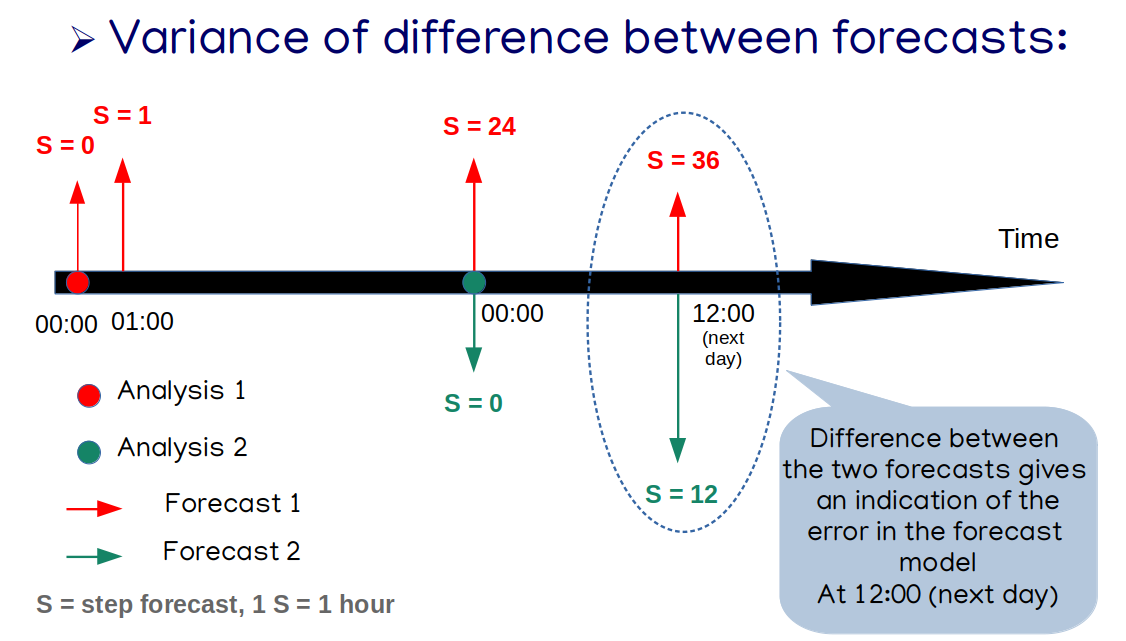

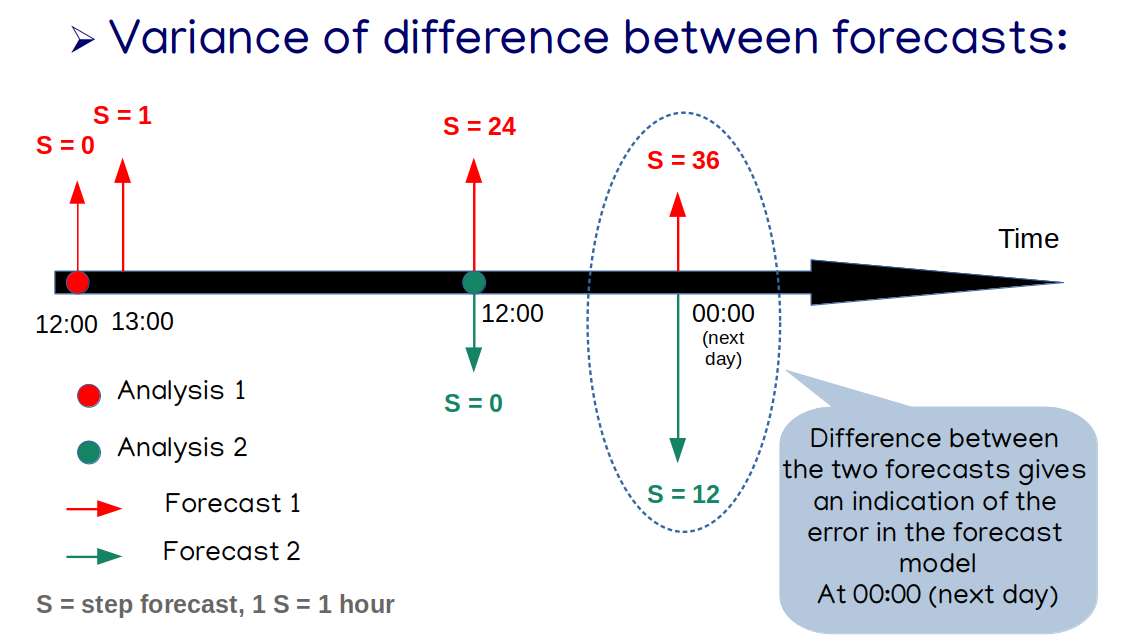

Because we are 'merging' two different times (by computing the difference between the forecasts), we need to re-define the ***time*** dimension of the resulting dataset (*reference* time): 

In [10]:
# Assign new time coordinates: reference time for the difference:

ds_00_00_A1['time'] = time_slice00 + step_36_hours  # Analysis 1 + 36 steps (12:00, next day, in this example)
ds_00_00_A2['time'] = time_slice00_NextDay + step_12_hours   # Analysis 2 + 12 steps (12:00, next day, in this example) 
ds_12_00_A1['time'] = time_slice12 + step_36_hours  # Analysis 1 + 36 steps (00:00, next day, in this example)
ds_12_00_A2['time'] = time_slice12_NextDay + step_12_hours   # Analysis 2 + 12 steps (00:00, next day, in this example)


Finally we compute the difference between the desired forecasts; here we concatenate the resulting datasets: 
- One dataset will provide the differences at 00:00 as reference time.
- The other dataset will refer to the differences at 12:00 as reference time.

In [11]:
# Lets use all the differences available (00:00 and 12:00)

ds= (xr.concat([(ds_00_00_A1-ds_00_00_A2)
              ,(ds_12_00_A1-ds_12_00_A2)], dim = "time")).chunk(chunks={'time':10,'values':50000})

ds['lsm'] = ds_00_00_A1['lsm'] # keep LandSeaMask available (when subtracting 'lsm' is cancelled) 


Now we are ready to compute the covariance in this dataset (in this version of the code, we compute only the diagonal terms):

In [12]:
# Compute covariances:
cov_a, cov_b = writeComputeCovariance(
    ds.where(ds.lsm[0,:] == 0), writeCovDir = era5_dir)

print(cov_a)
print(cov_b)

Working on: t
Variable: t, appended
List of indices: 
['1000_temp', '950_temp', '925_temp', '900_temp', '850_temp', '800_temp', '700_temp', '600_temp', '500_temp', '400_temp', '300_temp', '250_temp', '200_temp', '150_temp', '100_temp', '70_temp', '50_temp', '30_temp', '20_temp', '10_temp', '7_temp', '5_temp', '3_temp', '2_temp', '1_temp']
Working on: q


distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.32 GiB -- Worker memory limit: 7.80 GiB
distributed.worker - WARNING - Worker is at 55% memory usage. Resuming worker. Process memory: 4.34 GiB -- Worker memory limit: 7.80 GiB


Variable: q, appended
List of indices: 
['1000_temp', '950_temp', '925_temp', '900_temp', '850_temp', '800_temp', '700_temp', '600_temp', '500_temp', '400_temp', '300_temp', '250_temp', '200_temp', '150_temp', '100_temp', '70_temp', '50_temp', '30_temp', '20_temp', '10_temp', '7_temp', '5_temp', '3_temp', '2_temp', '1_temp', '1000_hum', '950_hum', '925_hum', '900_hum', '850_hum', '800_hum', '700_hum', '600_hum', '500_hum', '400_hum', '300_hum', '250_hum', '200_hum', '150_hum', '100_hum', '70_hum', '50_hum', '30_hum', '20_hum', '10_hum', '7_hum', '5_hum', '3_hum', '2_hum', '1_hum']
Working on: t2m
Variable: t2m, appended
List of indices: 
['1000_temp', '950_temp', '925_temp', '900_temp', '850_temp', '800_temp', '700_temp', '600_temp', '500_temp', '400_temp', '300_temp', '250_temp', '200_temp', '150_temp', '100_temp', '70_temp', '50_temp', '30_temp', '20_temp', '10_temp', '7_temp', '5_temp', '3_temp', '2_temp', '1_temp', '1000_hum', '950_hum', '925_hum', '900_hum', '850_hum', '800_hum', 

We can also visualize some of the data inside the dataset of errors or differences; in particular lets check on the mean (in time) of the wind speed component *u* difference:

Text(0.5, 1.0, 'Mean difference in u10n: mean( u10n(36h,A1)-u10n(12h,A2)) 12:00 and 00:00 mixed')

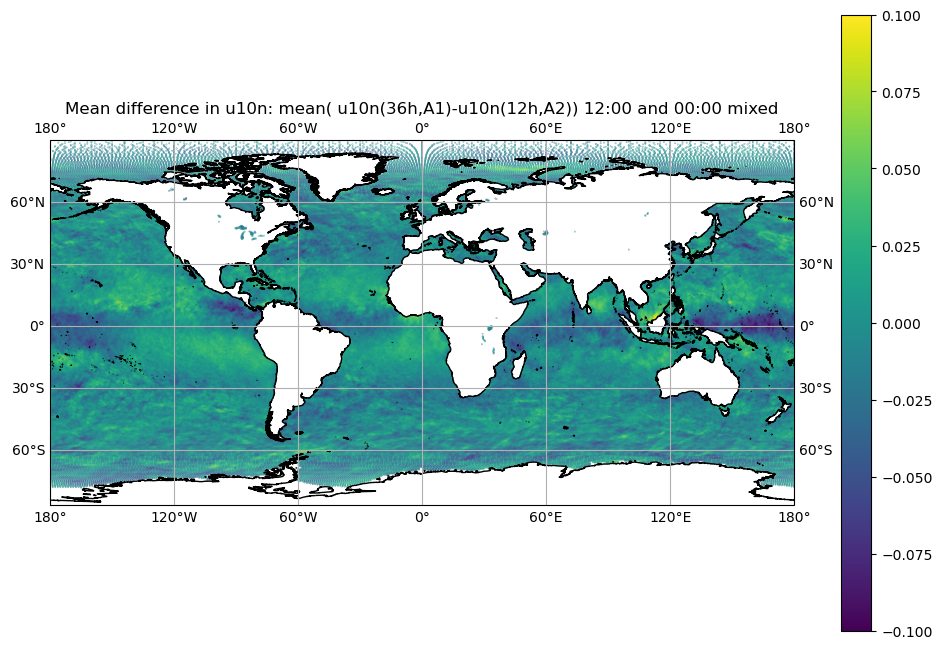

In [13]:
# Lets visualize some data:

da = ds.u10n.where(ds.lsm[0,:] == 0)

from matplotlib.cm import ScalarMappable

cmap = plt.get_cmap("viridis")
norm = plt.Normalize((da.mean(dim = "time")).values.min(), 
                     (da.mean(dim = "time")).values.max())

sm =  ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
time_index = 0
plt.scatter(x=da.longitude.values, 
            y=da.latitude.values,
            c=da.mean(dim = "time").values, s=0.05)

cbar = fig.colorbar(sm, ax=ax)

plt.title('Mean difference in u10n: mean( u10n(36h,A1)-u10n(12h,A2)) 12:00 and 00:00 mixed')
#plt.savefig('std_error_v10n.png',dpi =150)  

We can also check on the distribution of the differences between the 36 and 12 forecasts; I am using this construction to build a histogram, because at the time of this Notebook, I was obtaining funny histograms using *xarray*'s API (say dataarray.plot.hist()):

In [14]:
# Computing histogram of all the values contained in dataarray da:
# We resort to this way of computing the histogram because
# the normal xarray.plot.hist produced strange plots:

datamin = np.nanmin(da.values)
datamax = np.nanmax(da.values)
numbins = 20

delta = (datamax-datamin)/numbins
mybins =np.linspace(datamin+delta/2,
                    datamax-delta/2,
                    numbins) # Bins midpoint locations

hist, _ = np.histogram(da.isel(time=0).values.ravel(), bins = numbins,
                       range=(np.nanmin(da.isel(time=0)),np.nanmax(da.isel(time=0))))
for i in range(1, len(da["time"])):
    hist += np.histogram(da.isel(time=i).values.ravel(), bins = numbins,
                        range=(np.nanmin(da.isel(time=i)),np.nanmax(da.isel(time=i))))[0]


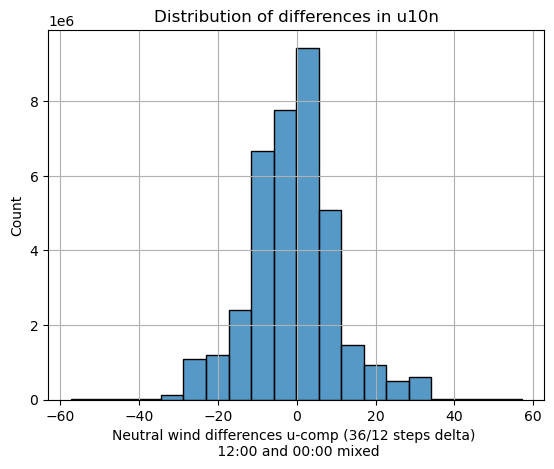

In [15]:
# Plot histogram using seaborn:
plt.figure()
sns.histplot(x=mybins, weights=hist, discrete=False, bins=numbins)
plt.xlabel('Neutral wind differences u-comp (36/12 steps delta) \n 12:00 and 00:00 mixed')
plt.grid(visible=True)
plt.title('Distribution of differences in u10n')
plt.savefig('hist_error_u10n.png',dpi =150) 

(array([5.4000e+01, 2.4900e+02, 7.3100e+02, 1.3790e+03, 2.7780e+03,
        6.6960e+03, 1.6375e+04, 3.3974e+04, 5.9073e+04, 7.7118e+04,
        7.4992e+04, 5.4775e+04, 3.0399e+04, 1.1256e+04, 2.4700e+03,
        5.4500e+02, 1.1100e+02, 4.2000e+01, 2.6000e+01, 1.0000e+01]),
 array([-1.01727169, -0.90852776, -0.79978384, -0.69103992, -0.58229599,
        -0.47355207, -0.36480815, -0.25606423, -0.1473203 , -0.03857638,
         0.07016754,  0.17891146,  0.28765539,  0.39639931,  0.50514323,
         0.61388716,  0.72263108,  0.831375  ,  0.94011892,  1.04886285,
         1.15760677]),
 <a list of 20 Patch objects>)

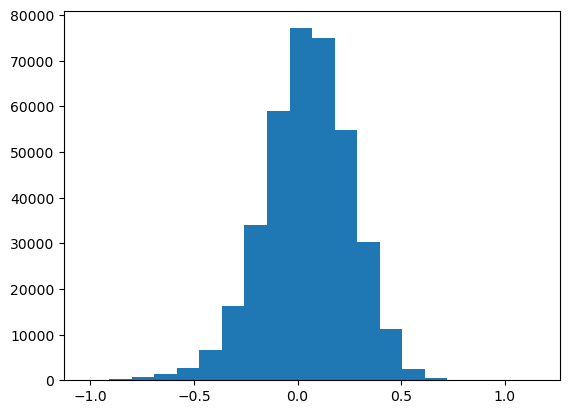

In [16]:
# Compute histogram of mean of error and plot using plt.hist:

da_m = (ds.u10n.where(ds.lsm[0,:] == 0)).mean(dim='time')
datamin_m = np.nanmin(da_m.values)
datamax_m = np.nanmax(da_m.values)
numbins_m = 20

delta_m = (datamax_m - datamin_m) / numbins_m
mybins_m = np.linspace(datamin_m + delta_m/2,
                    datamax_m - delta_m/2,
                    numbins_m) # Bins midpoint locations

hist_m, _ = np.histogram(da_m.values.ravel(), bins = numbins_m,
                       range=(np.nanmin(da_m.values),np.nanmax(da_m.values)))
plt.clf()
#sns.histplot(x = mybins_m, weights=hist_m, discrete=True)
plt.hist(x = mybins_m, weights=hist_m, bins = numbins_m)

Text(0.5, 1.0, 'Distribution of mean error in u10n')

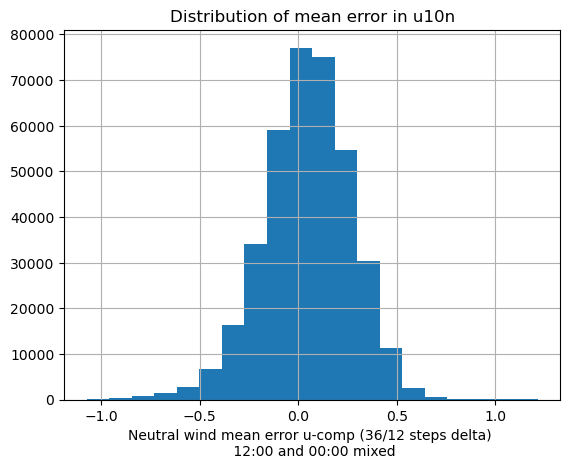

In [17]:
# Ploting mean of error using xarray plot histogram; the mean values histogram works properly

(ds.u10n.where(ds.lsm[0,:] == 0)).mean(dim='time').plot.hist(bins=20,)

plt.xlabel('Neutral wind mean error u-comp (36/12 steps delta) \n 12:00 and 00:00 mixed')
plt.grid(visible=True)
plt.title('Distribution of mean error in u10n')
#plt.savefig('hist_mean_error_u10n.png',dpi =150)  

# Risks and advantages of the NMC method to estimage background error variances [2]

## Potential risks:
- Understimate variances in data-sparse regions.
- Lenght of the forecasts used for computing the differences (i.e 12 and 36 hours) are longer than the lenght of the forecast used as background (apriori) data.

## Advantages:
- Forecasts used to compute the variances are already available in operational archives (i.e. flexible for testing).
- The NMC method has been used, published and discussed broadly: it's a rough, but firm first step for background error variances estimation.

## References:

[1] D. Parrish, J. Derber, "The National Meteorological Center's Spectral Statistical-Interpolation Analysis System", AMS, 1992.
[2] M. Fisher, "Background Error Covariance Modelling", Seminar on recent developments in data assimilation for atmosphere and ocean, ECMWF, 8-12 September 2003, available online: https://www.ecmwf.int/en/elibrary/9404-background-error-covariance-modelling